In [1]:
# install.packages("superml")
# install.packages("car")

In [2]:
library(ggplot2)
library(superml)
library(tidyverse)
library(reshape2)
library(caret)
library(car)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'superml' was built under R version 3.6.3"Loading required package: R6
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: carData
Warning me

In [3]:
options(repr.plot.width=4, repr.plot.height=4)

# Dataset

[Medical Cost Personal Dataset - Kaggle](#https://www.kaggle.com/mirichoi0218/insurance)

In [4]:
df <- read.csv("Data\\insurance.csv")
head(df)

age,sex,bmi,children,smoker,region,charges
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
31,female,25.740,0,no,southeast,3756.622


In [5]:
dim(df)

[1] 1338    7

In [6]:
names(df)

[1] "age"      "sex"      "bmi"      "children" "smoker"   "region"   "charges"

In [7]:
summary(df)

      age            sex           bmi           children     smoker    
 Min.   :18.00   female:662   Min.   :15.96   Min.   :0.000   no :1064  
 1st Qu.:27.00   male  :676   1st Qu.:26.30   1st Qu.:0.000   yes: 274  
 Median :39.00                Median :30.40   Median :1.000             
 Mean   :39.21                Mean   :30.66   Mean   :1.095             
 3rd Qu.:51.00                3rd Qu.:34.69   3rd Qu.:2.000             
 Max.   :64.00                Max.   :53.13   Max.   :5.000             
       region       charges     
 northeast:324   Min.   : 1122  
 northwest:325   1st Qu.: 4740  
 southeast:364   Median : 9382  
 southwest:325   Mean   :13270  
                 3rd Qu.:16640  
                 Max.   :63770  

# Data exploration

This section is about exploring the data by scatter plots, box plots, and correlations to find out relations between attributes. The findings shall be used in the later phase for building models.

## Visualising data: 

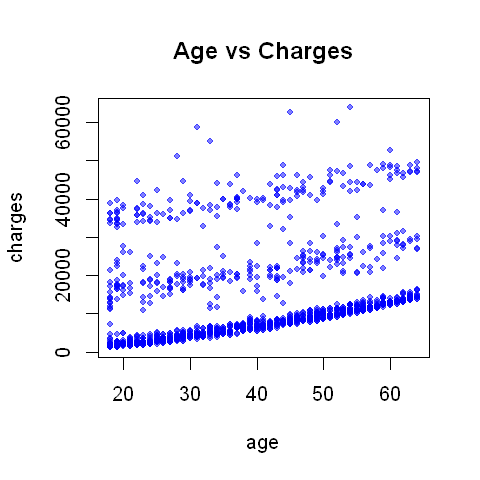

In [8]:
scatter1 <- plot(df$age, df$charges, main = "Age vs Charges", xlab = "age", ylab = "charges",
     col = alpha('blue',0.5), pch=20)

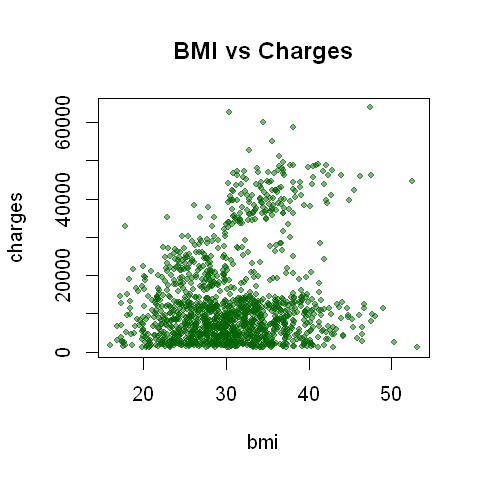

In [9]:
scatter2 <- plot(df$bmi, df$charges, main = "BMI vs Charges", xlab = "bmi", ylab = "charges",
     col = alpha('dark green',0.5), pch=20)

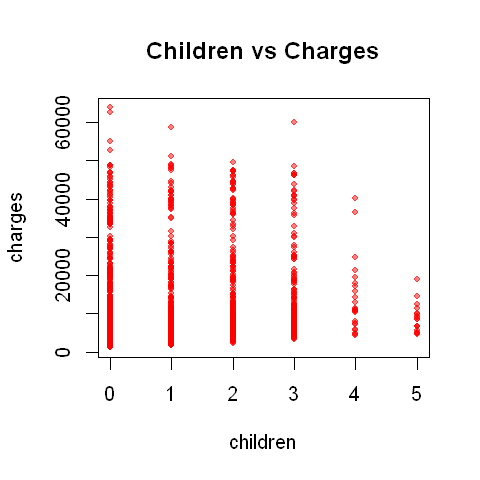

In [10]:
scatter3 <- plot(df$children, df$charges, main = "Children vs Charges", xlab = "children", ylab = "charges",
     col = alpha('red',0.5), pch=20)

Regarding the scatter plots, we can notice that age and charges share an increasing trend. 

While in BMI vs charge, the trend is less visible, but as bmi increase, there is a higher number of occurence of samples with more expensive charge. The correlation between the number of children and charge is not remarkable.

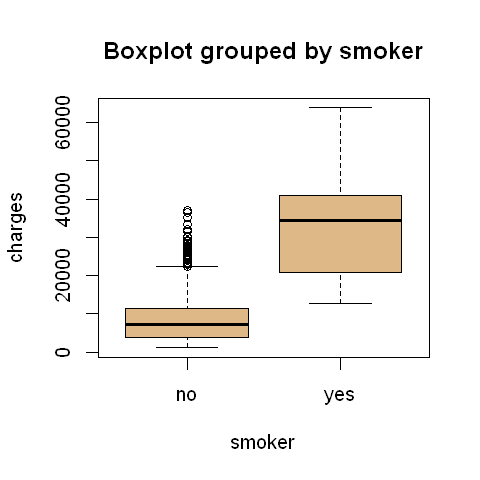

In [11]:
boxplot(df$charges ~ df$smoker, xlab = 'smoker', ylab = 'charges', 
        col ='burlywood', main = 'Boxplot grouped by smoker')

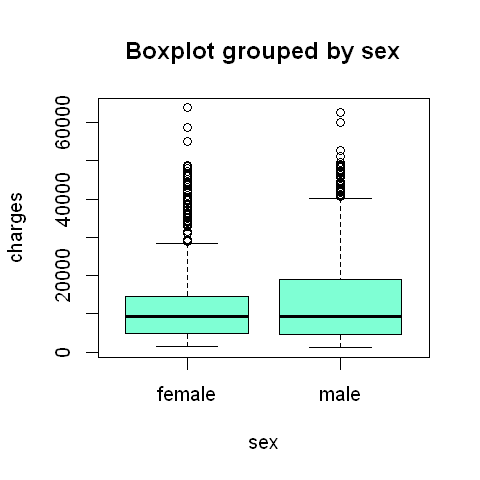

In [12]:
boxplot(df$charges ~ df$sex, xlab = 'sex', ylab = 'charges', 
        col ='aquamarine', main = 'Boxplot grouped by sex')

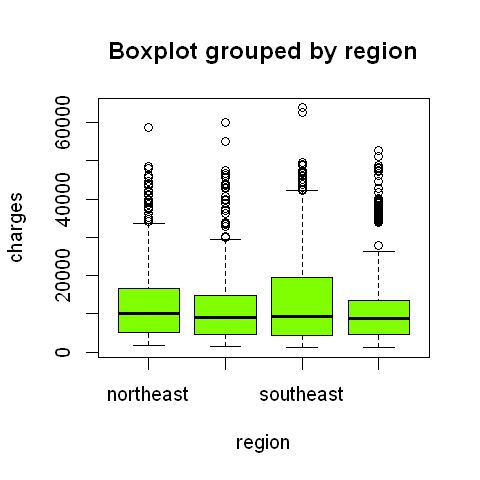

In [13]:
boxplot(df$charges ~ df$region, xlab = 'region', ylab = 'charges', 
        col ='chartreuse', main = 'Boxplot grouped by region')


Smokers have much higher medical expenses than non-smokers.This should be regarded as an important factor. On the contrary, gender and region have no significant influences on the charges

## Correlation: 

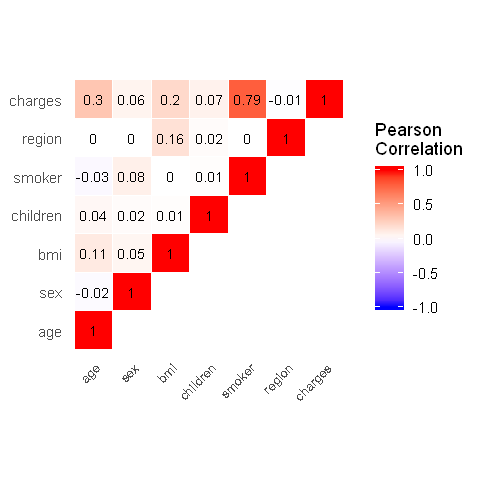

In [14]:
#Temporarily convert categorical to numeric 
df2 <- data.frame(df)
label <- LabelEncoder$new()
df2$smoker <- label$fit_transform(df2$smoker)
df2$sex <- label$fit_transform(df2$sex)
df2$region <- label$fit_transform(df2$region)

cormat <- round(cor(df2),2)

cormat[upper.tri(cormat)] <- NA #replace upper triangle of the matrix by NaN
melted_cormat <- melt(cormat, na.rm = TRUE)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Pearson\nCorrelation") +
  theme_minimal()+ 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 8, hjust = 1))+
  coord_fixed() +
  geom_text(aes(Var2, Var1, label = value), color = "black", size = 3) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank(),
    axis.ticks = element_blank(),
    legend.direction = "vertical")

As can be seen from the heatmap, smoker have high degree of correlation to charges. Also, age have moderate correlation, followed by BMI. Other attributes have low to almost no correlation to Charges.

# Model & hypotheses

In this section, we will build linear regression models to predict the personal medical charges. Also, the models will be compared and evaluate so that we can choose the best-fit one.

As inferred from previous section, age, BMI, smoking have the highest correlation to charges among all attributes. Therefore, the initial multiple regression model would be:

charges ~ age + bmi + smoker

From the above formula, we build a regression model using R’s lm() function. The snapshot below is the model summary, and we will explain and interpret some of the coefficients.


In [15]:
r1 <- lm(charges ~ age + bmi + smoker, data = df)
summary(r1)


Call:
lm(formula = charges ~ age + bmi + smoker, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12415.4  -2970.9   -980.5   1480.0  28971.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -11676.83     937.57  -12.45   <2e-16 ***
age            259.55      11.93   21.75   <2e-16 ***
bmi            322.62      27.49   11.74   <2e-16 ***
smokeryes    23823.68     412.87   57.70   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6092 on 1334 degrees of freedom
Multiple R-squared:  0.7475,	Adjusted R-squared:  0.7469 
F-statistic:  1316 on 3 and 1334 DF,  p-value: < 2.2e-16


* The model for predicting charges using smoking, age, BMI is:

   **charges = -11676.83 + (259.55 * age) + (322.62 * BMI) + (238223.68 * smoker) + error.**

* From the *Pr(>|t|)* values, we are can support the claim that age, bmi and smoking have significant influence on charges.

* Multiple R-squared is 0.7475. This value represents the square R between age and charges and indicates that 74.75% of the variation in the outcome variable charges can be explained by the predictors. 

* The adjusted R-square (0.7494) is almost equal to the multiple R-square. This is due to the fact that this is a relatively simple model with only three explanatory variables.

* From the Fstatistic result (p-value << 0.001), we can conclude that the model is good and that the predictor variables are all significant. 

Next, we try to improve this model by including the predictor variables sex, children and region. 

In [16]:
r2 <- lm(charges ~ age + bmi + children + region + sex + smoker, data = df)
summary(r2)


Call:
lm(formula = charges ~ age + bmi + children + region + sex + 
    smoker, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11938.5      987.8 -12.086  < 2e-16 ***
age                256.9       11.9  21.587  < 2e-16 ***
bmi                339.2       28.6  11.860  < 2e-16 ***
children           475.5      137.8   3.451 0.000577 ***
regionnorthwest   -353.0      476.3  -0.741 0.458769    
regionsoutheast  -1035.0      478.7  -2.162 0.030782 *  
regionsouthwest   -960.0      477.9  -2.009 0.044765 *  
sexmale           -131.3      332.9  -0.394 0.693348    
smokeryes        23848.5      413.1  57.723  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6062 on 1329 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7494 
F-statistic: 500.8 on 8 and 1329 DF,

In this updated model the multiple R square is 0.7509, meaning that the new model explains 75.09 of the variation in charges. 

Looking at the coefficients, we find that sex attribute is not significant (p-value is 0.69). Therefore, we remove the attribute sex from the model and reevaluate it.


In [17]:
r3 <- lm(charges ~ age + bmi + children + region + smoker, data = df)
summary(r3)


Call:
lm(formula = charges ~ age + bmi + children + region + smoker, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11367.2  -2835.4   -979.7   1361.9  29935.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11990.27     978.76 -12.250  < 2e-16 ***
age                256.97      11.89  21.610  < 2e-16 ***
bmi                338.66      28.56  11.858  < 2e-16 ***
children           474.57     137.74   3.445 0.000588 ***
regionnorthwest   -352.18     476.12  -0.740 0.459618    
regionsoutheast  -1034.36     478.54  -2.162 0.030834 *  
regionsouthwest   -959.37     477.78  -2.008 0.044846 *  
smokeryes        23836.30     411.86  57.875  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6060 on 1330 degrees of freedom
Multiple R-squared:  0.7509,	Adjusted R-squared:  0.7496 
F-statistic: 572.7 on 7 and 1330 DF,  p-value: < 2.2e-16


After removing attribute sex from the model, we can observe that the model still explains 75.09 per cent of the variation in charges. Next, we will compare the initial model and the current one using ANOVA.

### ANOVA

In [18]:
anova(r1, r3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1334,49513219514,NA,NA,NA,NA
1330,48845249273,4,667970241,4.547015,0.001191318


The p-value is significant (0.001 < 0.01), so we conclude that our third model provides a better fit than our initial model.

In [19]:
anova(r2, r3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1329,48839532844,NA,NA,NA,NA
1330,48845249273,-1,-5716429,0.155553,0.6933475


Comparing the second and the third model, the p-value is non-significant (0.69 >> 0.01). Therefore, we conclude that there is no significant difference between two models’ performances. 

Since the third model has one less variable than the second model, we decide that the former is the most prominent. 


### Standardized residual

In [20]:
standard_res <- rstandard(r3)
sum(standard_res < -2 | standard_res >2)/ length(standard_res)

[1] 0.05007474

In [21]:
sum(standard_res < -3 | standard_res >3)/ length(standard_res)

[1] 0.02092676

Upon calculation, the proportion of samples with an absolute value of standardized residual greater than 2 is 5.01 percent, and greater than 3 is 2.1 percent. This rate is of outliers is acceptable.

### Variance Inflation Factor

The table below shows the VIF test result. A VIF higher than 5 indicates high correlation. Since none of the VIF values is higher than 5, we can claim that there is no multicolinearity.

In [22]:
vif(r3)

,GVIF,Df,GVIF^(1/(2*Df))
age,1.016188,1,1.008061
bmi,1.104197,1,1.050808
children,1.003714,1,1.001855
region,1.098870,3,1.015838
smoker,1.006369,1,1.003179


### Residualplot & QQ plot

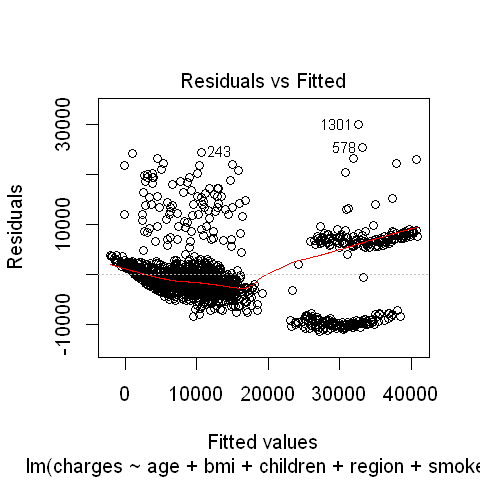

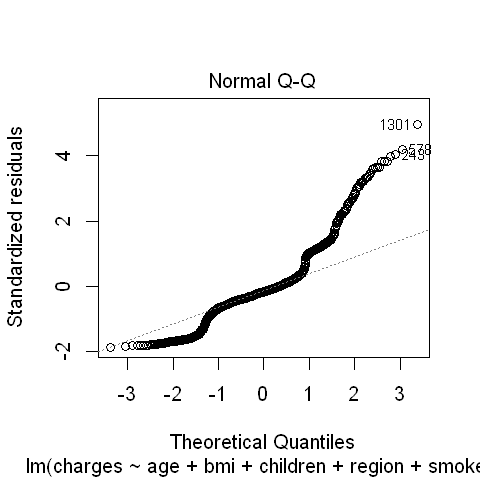

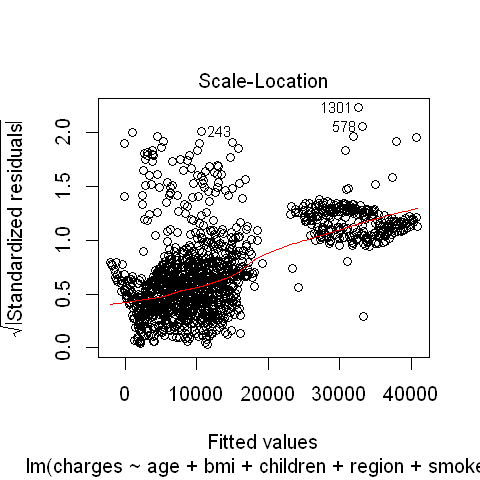

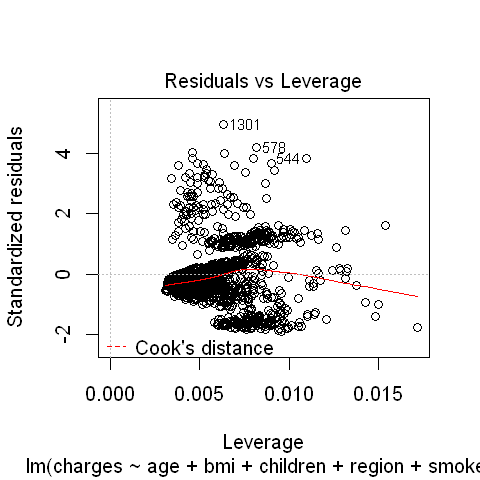

In [23]:
c <- plot(r3)

In the Residual vs fitted, the dots seem not to be randomly placed around the horizontal zero line. There are there distinguishable groups. Our conclusion is that there might be other factors that are not taken into account of, which means there is an additional varible (perhaps a categorical one with 3 categories) that is not included in the dataset.

There might also be a non-linear relationship between the charge and the predictor variables. This will be inspected in the following plot.


The non-linear relationship is also reflected by the second plot (Q-Q plot) since the dots deviate from the dotted line.

# Results & Conclusion
From the research, we find that age, BMI, number of children, and smoking are the most influential factors to a person’s medical charge. Among this smoking seems to affect the most on the medical expenses. On the contrary, region and gender do not contribute much to the change in medical charges.
 
Our final linear regression model explains 75% of the data, which is a good result. However, there seems to be non-linear relationships between healthcare cost and predictors. Also, there might be hidden patterns that are not explained by the data due to the lack of variables.
